# Solución de problemas con KMeans

En este tutorial aprenderás cómo crear un modelo de agrupación haciendo uso del algoritmo KMeans. En particular, realizarás una selección del hiperparámetro k mediante el método del codo y el método de la silueta, interpretando los grupos del mejor modelo de agrupación resultante. En este sentido, veremos cómo realizar los siguientes procesos:

1. Importar las librerías necesarias.
2. Cargar un conjunto de datos.
3. Explorar el conjunto de datos.
4. Limpiar y preparar los datos para el modelado.
5. Seleccionar el hiperparámetro K mediante el método del codo y el método de la silueta.
6. Interpretar los grupos resultantes del mejor modelo.

Utilizaremos el conjunto de datos correspondiente al comportamiento de clientes con tarjetas de crédito. En este problema queremos agrupar a los clientes según el uso que le dan a sus tarjetas de crédito.

## 1. Importación de librerías requeridas

Importaremos las librerías `pandas`, `matplotlib`, `numpy` y `scikit-learn`. En particular, usaremos las siguientes clases y funciones para entrenar y evaluar el modelo de KMeans:

* `SimpleImputer()`: clase para reemplazar datos nulos.
* `StandardScaler()`: clase para estandarizar los datos.
* `make_blobs()`: función para generar grupos gaussianos separables.
* `silhouette_score()`: función para obtener el valor promedio del coeficiente de la silueta.
* `KMeans()`: clase para crear el modelo de KMeans.
* `Pipeline()`: clase para crear Pipelines.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

## 2. Carga de datos

Realizaremos la carga de datos usando la función de Pandas `read_csv()`, especificando la ruta y el separador del archivo:

In [2]:
data_raw = pd.read_csv('data/creditcard_data.csv', sep=',')

Veamos los primeros datos del conjunto utilizando `head()`:

In [3]:
data_raw.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Como puedes observar, nuestro conjunto de datos solamente contiene variables numéricas, lo cual facilitará nuestro análisis de agrupación.

## 3. Exploración del conjunto de datos

Primero utilizaremos `data_raw.describe()` para obtener una descripción de las variables del conjunto de datos. Puedes observar que variables como `PURCHASES` y `BALANCE_FREQUENCY` tienen rangos muy diferentes.

In [4]:
data_raw.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


## 4. Limpieza y preparación de datos

Primero vamos a definir la variable `data` para almacenar un conjunto de datos modificado, utilizando el método `copy()`:

In [5]:
data = data_raw.copy()

### Eliminación de variables poco relevantes

Este conjunto de datos solo tiene una variable poco relevante para realizar la agrupación: `CUST_ID`. Haciendo uso de la función `drop()`, eliminaremos esta variable del DataFrame:

In [6]:
data = data.drop('CUST_ID', axis=1)

### Tratamiento de nulos y duplicados

Posteriormente, revisaremos si nuestros datos contienen datos nulos usando `isna().sum()`:

In [7]:
data.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Como puedes observar, se tienen datos nulos en las variables `CREDIT_LIMIT` y `MINIMUM_PAYMENTS`. Ahora veremos si hay duplicados utilizando `duplicated().sum()`:

In [8]:
data.duplicated().sum()

0

Como no tenemos datos duplicados, solamente debemos tratar los datos nulos. En vez de eliminarlos, utilizaremos un objeto de la clase `SimpleImputer` para reemplazar los valores `np.nan` con la media de la variable:

In [9]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

Recuerda que, al tratarse de un algoritmo no supervisado, no realizaremos división de datos al no contar con etiquetas. Por lo tanto, pasaremos directamente a la estandarización de nuestros datos.

### Estandarización

KMeans calcula distancias entre puntos, por lo que realizaremos una estandarización para que la escala de la variable no tenga influencia sobre las distancias calculadas. Utilizaremos un objeto de la clase `StandardScaler()` que, por cada variable, elimina la media y la escala hasta llegar a una varianza unitaria:

In [10]:
scaler = StandardScaler()

## 5. Selección del hiperparámetro K

Inicialmente crearemos un objeto de la clase `KMeans` para ejecutar el algoritmo de agrupación. Especificaremos un máximo de iteraciones con el parámetro `max_iter` y la semilla con el parámetro `random_state`:

In [11]:
kmeans = KMeans(max_iter=300, random_state=0)

Posteriormente, construiremos nuestro pipeline de procesamiento y entrenamiento con los objetos `imputer`, `scaler` y `kmeans`:

In [12]:
pipe = Pipeline(steps=[("imputer", imputer), ("scaler", scaler), ("model", kmeans)])

## Método del codo

Primero intentaremos buscar el mejor valor de _k_, representado por el parámetro `n_clusters` de `KMeans`, mediante el método del codo. En ese sentido, definiremos la función `elbow_plot()`, que ejecutará KMeans con cada valor de _k_ definido por el rango `[k_min, k_max]`. Adicionalmente, generará una gráfica con los valores de inercia, es decir, con la suma de los cuadrados de las distancias de todos los puntos al centroide más cercano:

In [13]:
def elbow_plot(data, k_min=2, k_max=10):
    """
    Genera la gráfica para el método del codo
    
    Parametros:
    data : np.array
        El arreglo con los datos
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    inertias = []
    for i in range(k_min, k_max+1):
        # Modificamos el parámetro k
        pipe.set_params(model__n_clusters=i)
        # Ejecutamos el pipeline, entrenando el modelo de KMeans
        pipe.fit(data)
        # Almacenamos el valor de inercia
        inertias.append(pipe['model'].inertia_)
    
    # Graficamos los valores de inercia
    plt.plot(range(k_min,k_max+1), inertias, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Inercia')
    plt.grid()
    plt.show()

Con la función construida, veremos el comportamiento para nuestro conjunto de datos:

/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

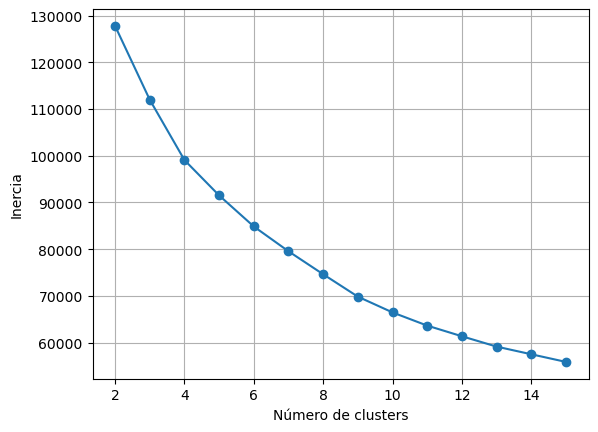

In [14]:
elbow_plot(data, 2, 15)

El mejor valor de _k_ se determina con el punto después del cual la inercia empieza a tener un comportamiento aproximadamente lineal, es decir, cuando el aumento del número de grupos no representa una disminución considerable de la inercia. Ten en cuenta que este método es una heurística que puede o no ser efectiva dependiendo de los datos, por lo que en situaciones donde la inercia no tiene un codo claro, como en la gráfica anterior, la determinación del valor de _k_ no es evidente.

Por ejemplo, a continuación utilizaremos la función `make_blobs()` de `scikit-learn` para generar un conjunto de veinte datos descritos por dos variables, con tres grupos fácilmente separables:

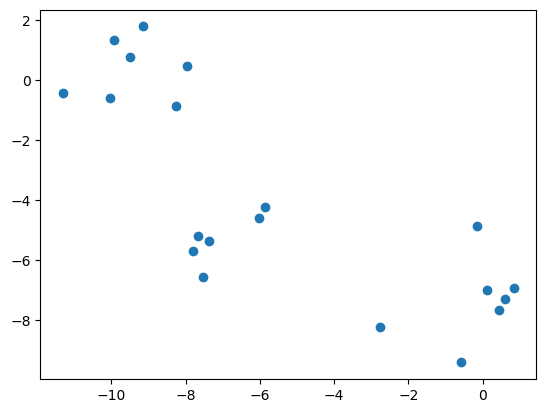

In [15]:
x_blobs, y_blobs = make_blobs(n_samples=20, centers=3, n_features=2, random_state=9)
plt.scatter(x_blobs[:,0], x_blobs[:,1])

Como puedes observar, la función `make_blobs()` genera las etiquetas de los clusters, que almacenamos en `y_blobs` pero no utilizaremos. En cambio, utilizaremos los datos almacenados en `x_blobs` para ejecutar la misma función `elbow_plot()`:

/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

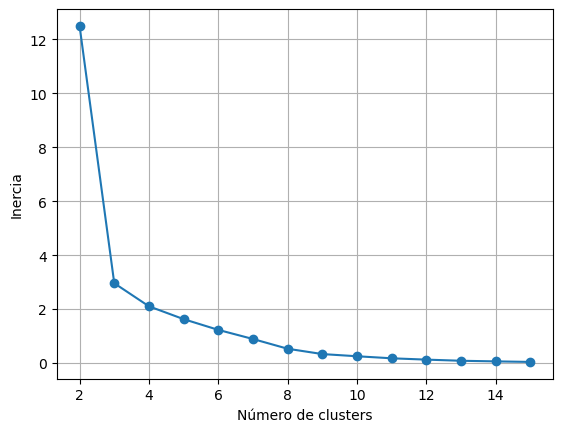

In [16]:
data_blobs = pd.DataFrame(x_blobs)
elbow_plot(data_blobs, 2, 15)

Puedes observar que se presenta un codo claro en _k_ = 3, en el que el comportamiento de la función cambia y un aumento de _k_ no representa una disminución considerable en la inercia (comparada con la disminución entre 2 y 3). Entonces, para este conjunto de datos el mejor _k_ es 3, como lo definimos inicialmente.

## Método de la silueta

El método de la silueta es un tipo de análisis que mide la separación entre los clusters obtenidos en algoritmos de agrupación. Específicamente, el coeficiente de la silueta es un valor calculado utilizando la distancia entre clusters y la distancia al cluster más cercano para cada dato, retornando un valor entre -1 y 1. Valores cercanos a 1 indican que un dato está lejos de los demás clusters, mientras que valores cercanos a -1 indican que un dato está más cerca a otro cluster que al que fue asignado.

Para este análisis, utilizaremos la función `silhouette_score()` de `scikit-learn`, que retorna el promedio del coeficiente de la silueta para todos los datos del conjunto. En ese sentido, un valor promedio cercano a 1 nos indicaría que el número de clusters es apropiado para el conjunto de datos, mientras que valores más bajos indicarían que el valor de _k_ no retorna buenos clusters. Definiremos la función `silhouette_plot()`, que calcula el coeficiente promedio para varios valores de _k_ y los grafica:

In [17]:
def silhouette_plot(data, k_min=2, k_max=5):
    """
    Genera la gráfica con el coeficiente de la silueta
    
    Parametros:
    data : np.array
        El arreglo con los datos
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    scores = []
    for i in range(k_min, k_max+1):
        # Modificamos el parámetro k
        pipe.set_params(model__n_clusters=i)
        # Ejecutamos el pipeline, entrenando el modelo de KMeans
        pipe.fit(data)
        # Procesamos los datos
        imputer_data = imputer.fit_transform(data)
        clean_data = scaler.fit_transform(imputer_data)
        # Almacenamos el coeficiente de la silueta
        score = silhouette_score(clean_data, pipe['model'].labels_)
        scores.append(score)
    
    # Graficamos los valores del coeficiente de la silueta
    plt.plot(range(k_min,k_max+1), scores, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Silhouette Score')
    plt.grid()
    plt.show()

Veremos el comportamiento del coeficiente para nuestro conjunto de datos:

/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

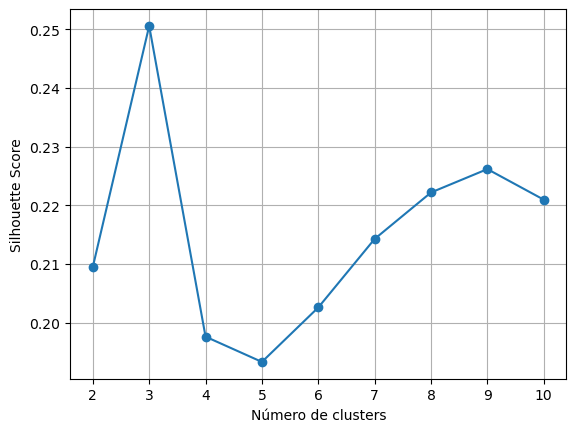

In [18]:
silhouette_plot(data, 2, 10)

Como puedes observar, aunque se tienen valores bajos, es más evidente que el mejor valor de _k_ es 3, al ser el valor más cercano a 1 para el coeficiente de la silueta. Sin embargo, es posible que nuestro conjunto de datos no tenga grupos fácilmente separables, lo que explicaría los resultados obtenidos con el método del codo y de la silueta.

De igual manera, podemos ver el comportamiento del método de la silueta para los datos generados con `make_blobs()`:

/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

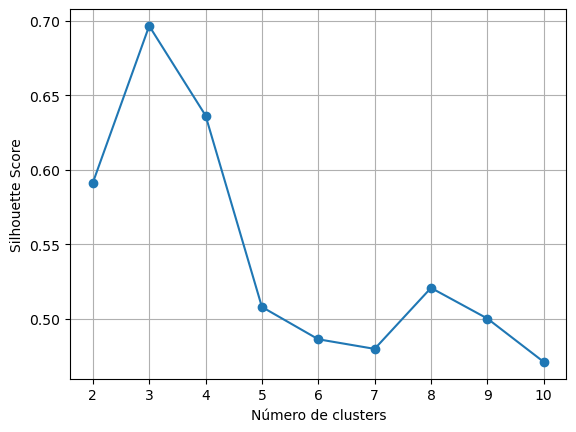

In [19]:
silhouette_plot(data_blobs, 2, 10)

En este caso se tiene un comportamiento similar al observado en los datos de nuestro problema, pero con valores más altos para el coeficiente de la silueta (con un pico de 0.7). Al igual que con el método del codo, podemos determinar que el mejor _k_ para los datos generados con `make_blobs()` es 3.

## 6. Interpretación de los grupos resultantes del mejor modelo

Con el mejor valor de _k_, primero ejecutaremos el algoritmo de KMeans:

In [20]:
pipe.set_params(model__n_clusters=3)
pipe.fit(data)

/Users/alejandraossayepes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=3, random_state=0))])

Primero veremos cuántos datos hay en cada grupo, lo que nos indicará qué tantos clientes tienen comportamientos similares. Para esto utilizaremos el atributo `labels_`, que retorna un arreglo con el índice del grupo al que pertenece cada dato. Además usaremos la función `unique()` de `numpy`, que retorna los valores únicos (que almacenamos en la variable `indexes`) y la cantidad de datos por cada uno (que almacenamos en la variable `values`):

In [21]:
labels = pipe['model'].labels_
indexes, values = np.unique(labels, return_counts=True)

{indexes[i]: values[i] for i in range(len(indexes))}

{0: 1235, 1: 6119, 2: 1596}

También podemos usar `plt.bar()` para graficar estos valores:

([<matplotlib.axis.XTick at 0x18c60d490>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

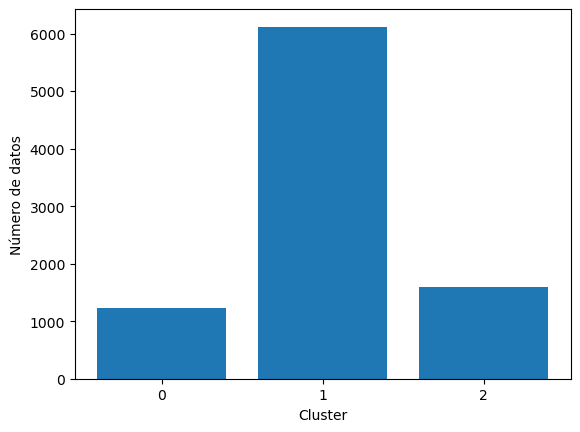

In [25]:
rects = plt.bar(indexes, values)
plt.xlabel('Cluster')
plt.ylabel('Número de datos')
plt.xticks(indexes)

A continuación, obtendremos los centroides de cada grupo con el atributo `cluster_centers_` del objeto `kmeans`. Transformaremos el arreglo resultante en un DataFrame con las columnas de la variable `data`:

In [23]:
centroids_array = pipe['model'].cluster_centers_
centroids = pd.DataFrame(centroids_array, columns=data.columns)
centroids

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.318798,0.439955,1.527871,1.279683,1.261207,-0.247131,1.143105,1.559745,0.957043,-0.358687,-0.251049,1.680394,0.891538,0.835329,0.155336,0.494645,0.303246
1,-0.367396,-0.177663,-0.232898,-0.204408,-0.175047,-0.309514,-0.062796,-0.234992,-0.048401,-0.334251,-0.298804,-0.243583,-0.336467,-0.284403,-0.135429,0.007045,-0.028208
2,1.161463,0.340325,-0.290464,-0.207468,-0.305709,1.377858,-0.644545,-0.307119,-0.555630,1.559078,1.339837,-0.367625,0.599350,0.443301,0.398847,-0.410076,-0.126713


Como puedes observar, los centroides están escalados porque incluimos el paso del `scaler` en nuestro pipeline. Para obtener valores que sean interpretables con los rangos iniciales de los datos, utilizaremos la función `inverse_transform()`:

In [24]:
centroids_transformed = scaler.inverse_transform(centroids)
centroids_transformed = pd.DataFrame(centroids_transformed, columns=data.columns)
centroids_transformed

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,2228.026120,0.981492,4267.525421,2716.449393,1551.561464,460.625971,0.949134,0.667760,0.744791,0.063367,1.535599,56.478155,7738.228155,4151.340126,1226.211303,0.298390,11.923139
1,799.771040,0.835184,505.615025,253.161504,252.774371,329.805632,0.465148,0.132355,0.345201,0.068257,1.209709,8.655280,3270.246492,909.825781,548.594759,0.155775,11.479568
2,3981.961277,0.957891,382.624762,248.083296,134.618954,3868.303195,0.231664,0.110838,0.143616,0.447132,12.392231,5.572055,6675.128161,3016.457991,1793.702161,0.033774,11.347744


Por ejemplo, el grupo 0 corresponde a clientes que tienen un balance en su cuenta de aproximadamente 2197 dólares (variable `BALANCE`), han gastado aproximadamente 4232 dólares en compras con su tarjeta (variable `PURCHASES`), se les han dado avances por aproximadamente 455 dólares (variable `CASH_ADVANCE`), y realizan compras con mucha frecuencia (variable `PURCHASES_FREQUENCY`).

## Cierre

En este tutorial hemos utilizado la clase `KMeans` para entrenar y evaluar un modelo de agrupación. Específicamente, realizamos una selección del hiperparámetro K mediante el método del codo y el método de la silueta, interpretando los K grupos resultantes.

---
Si quieres más información sobre KMeans para agrupación en `scikit_learn` puedes consultar el [sitio web oficial](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Para la estandarización de datos con la clase `StandardScaler()` puedes consultar [este enlace](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

Para información sobre el método de la silueta y la función `silhouette_score()`, puedes consultar [este enlace](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

Para la creación de Pipelines con la clase `Pipeline()` puedes consultar [este enlace](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

---
*Creado por: Nicolás Díaz*  
*Revisado por: Haydemar Nuñez*  
*Versión de: Agosto 31, 2023*  
*Universidad de los Andes*   